# Command Recognition using 2D Body Keypoints
## Introduction

In this notebook, we will train an LSTM network via [HRI-Gestures](https://findresearcher.sdu.dk/ws/portalfiles/portal/196521936/VISAPP_2022_178_CR.pdf) dataset. This research investigates the cross-subject and cross-repetition capabilities of the network.

This notebook created for the project course APPRAS-SS2023 at TU Berlin.

### Experiments

*   Base
> The whole dataset is used without any special partitioning. Later on, we will randomly split the data as train and test.
*   Cross-subject (CS)
> The dataset is splitted based on the number of subjects. This experiment investigates how the model is in capable of learning the features without biasing on the subjects.
*   Cross-repetition (CR)
> The dataset is splitted based on the repetition of the recordings. This experiment investigates how the model in capable of generalizing on different repetitions of the same recording.

In this work, 12 different action labels are selected from 20 different action labels provided by the dataset.

**Action list:**
*   Stop
*   Go right
*   Go left
*   Come here
*   Follow me
*   Get attention
*   Be quiet
*   Standing still
*   Being seated
*   Walking towards
*   Walking away
*   Talking on phone

In [79]:
from google.colab import drive
from tensorflow.keras.utils import to_categorical, split_dataset, pad_sequences, plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from sklearn.utils import shuffle
import numpy as np
import os
import sys

#### Helper Functions

In [ ]:
joint_dict = {'Nose': 0, 'LEye': 1, 'REye': 2, 'LEar': 3, 'REar': 4, 'LShoulder': 5, 'RShoulder': 6, 'LElbow': 7, 'RElbow': 8, 'LWrist': 9, 'RWrist': 10, 'LHip': 11, 'RHip': 12, 'LKnee': 13, 'RKnee': 14, 'LAnkle': 15, 'RAnkle': 16}
cam_dict = {'C001': 'Intel RealSense D415', 'C002': 'Intel RealSense D415', 'C003': 'Intel RealSense D415', 'C004': ' Intel RealSense D455'}
action_dict = {'STOP': 0, 'GO RIGHT': 1, 'GO LEFT': 2, 'COME HERE': 3, 'FOLLOW ME': 4, 'GET ATTENTION': 5, 'BE QUIET': 6, 'STANDING STILL': 7, 'BEING SEATED': 8, 'WALKING TOWARDS': 9, 'WALKING AWAY': 10, 'TALKING ON PHONE': 11}

def show_skeleton(skeleton, reverse=True, as_video=False, save_with_name="", frame=0):
  ###
  # Skeleton: (frame_count, 17, num of dimentions, e.g. 2)
  # reverse: The plot is upside down, set it to False when the original plot is needed
  # as_video: Generates and displays a video from the skeleton sequences
  # save_with_name: Saves a video from the skeleton sequences with the given file name,
  #                 ignored if as_video is set to False
  # frame: the frame number to plot the skeleton from,
  #         should not exceed the total frame count of the sequence
  ###

  frame_count = skeleton.shape[0] # Total frame count
  if frame_count <= frame:
    print("Frame count exceeded!")
    return

  # Create a new figure
  fig = plt.figure()
  ax = fig.add_subplot(111)

  # Define the connections between keypoints (assuming a specific order)
  connections = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8),
                (7, 9), (8, 10), (5, 11), (6, 12), (5, 6), (11, 12), (11, 13),
                (12, 14), (13, 15), (14, 16)]

  def update_frame(updated_frame):
    ax.cla()
    # Example skeleton data
    skeleton_data = np.array(skeleton)[updated_frame]  # List of skeleton data, each element is a matrix of shape (Frame count, 17, 2) representing the 2D locations

    if reverse:
      skeleton_data[:, 1] = skeleton_data[:, 1] * -1

    # Plot keypoints
    ax.scatter(skeleton_data[:, 0], skeleton_data[:, 1], marker='o')

    # Plot connections
    for connection in connections:
        ax.plot([skeleton_data[connection[0], 0], skeleton_data[connection[1], 0]],
                [skeleton_data[connection[0], 1], skeleton_data[connection[1], 1]])

    # Add keypoint labels
    for j, point in enumerate(skeleton_data):
        ax.text(point[0], point[1], str(j), fontsize=8)
    # Set plot limits and labels
    ax.set_xlim([-1, 1])  # Specify the width of your image, the height is derived from the data
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

  if as_video:
    rc('animation', html='jshtml')
    animation = FuncAnimation(fig, update_frame, frames=frame_count, interval=200)
    if save_with_name != "":
      animation.save(save_with_name + ".mp4")
    return animation
  else:
    update_frame(frame)
    plt.show()

def filter_data(data, lab):
  # Get indexes of discarded samples (only some labels are used)
  discarded = []
  for idx in range(len(lab)):
    if lab[idx].upper() not in list(action_dict.keys()):
      discarded.append(idx)
  # Remove discarded elements from the data
  print("Before --- Data length:", len(data), "-", "Label length:", len(lab))
  data_filtered = []
  labels_filtered = []
  for idx in range(len(lab)):
      # checking if element not present in index list
      if idx not in discarded:
          data_filtered.append(data[idx])
          labels_filtered.append(lab[idx])
  print("After --- Data length:", len(data_filtered), "-", "Label length:", len(labels_filtered))
  return data_filtered, labels_filtered

def get_min_max_frame_length(data_filtered):
  # Detect minimum and maximum frame length
  min_val = data_filtered[0].shape[0]
  max_val = data_filtered[0].shape[0]
  min_val_idx = 0
  max_val_idx = 0
  for i in range(len(data_filtered)):
      if data_filtered[i].shape[0] < min_val:
          min_val = data_filtered[i].shape[0]
          min_val_idx = i
      if data_filtered[i].shape[0] > max_val:
          max_val = data_filtered[i].shape[0]
          max_val_idx = i
  print('Min:', min_val, 'at', min_val_idx, '-', 'Max:', max_val, 'at', max_val_idx)
  return min_val, min_val_idx, max_val, max_val_idx

def get_false_preds(y_truth, preds):
  # Pick false classifications
  false = []
  for idx in range(len(preds)):
    if y_truth[idx] != preds[idx]:
      false.append(preds[idx])
  return false

def one_hot_to_category_idx(y_test):
  # Convert one hot encoded vectors into category indexes
  y_truth = []

  for y in y_test:
      category = [cat for cat in range(y.shape[0]) if y[cat] == 1][0]
      y_truth.append(category)
  return y_truth

def plotConfusionMatrix(y_truth, preds):
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  confusion_matrix = confusion_matrix(y_truth, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix)
  disp.plot()

def plot_label_counts(labels):
  import pandas
  from collections import Counter
  label_counts = Counter(labels)
  df = pandas.DataFrame.from_dict(label_counts, orient='index')
  min_val = max(min(list(label_counts.values())) - 50, 0)
  df.plot(kind='bar', ylim=min_val, legend=None)

def print_F1_scores(y_truth, preds):
  from sklearn.metrics import f1_score
  f1_scores = f1_score(y_truth, preds, average=None)
  print('--------- F1 Scores ---------')
  for idx in range(len(f1_scores)):
    print(list(action_dict.keys())[idx]+':', f1_scores[idx])
  print('Weighted average:', f1_score(y_truth, preds, average='weighted'))


In [ ]:
### Use the dataset stored in the Google Drive
#drive.mount('/content/drive')

In [ ]:
### Get the dataset from the cloud and unzip
#!wget https://nextcloud.sdu.dk/index.php/s/AiyBziPXNGFmTTw/download/skeletons.zip
#!wget https://tubcloud.tu-berlin.de/s/tfi7AJoEPR312gyJ3/download/HRI_data.zip
#!unzip skeletons.zip
#!unzip HRI_data.zip

In [ ]:
### Parser for reading the dataset
# If only file_dir is given:
#   returns
#     the data as a list where each is a numpy array with shape (Frame count, Num of keypoints e.g. 17, Num of datapoints e.g. 5)
#     the labels with the same index
# If split_subjects or split_repetition is set (between 0.0 and 1.0):
#   splits the data based on the ratio set
#   returns in addition:
#     test_data in the same format
#     test_labels in the same format
# If detailed is set to True:
#   prints detailed logs while reading the file
#   returns in addition:
#     missing_data containing the subject id and the missing entry

def get_data_HRI(file_dir: str, detailed=False, split_subjects=0.0, split_repetition=0.0) -> (np.ndarray, list):
    '''
    Reads in the whole HRI dataset and creates a data array and their corresponding labels
    :param file_dir: Path to root directory of HRI dataset (example: '../data/HRI_gestures')
    :return: (data, labels) -> both as np.ndarray
    '''
    action_class = {'A001': 'Stop', 'A002': 'Go Right', 'A003': 'Go Left', 'A004': 'Come Here', 'A005': 'Follow me',
                    'A006': 'Go Away', 'A007': 'Agree', 'A008': 'Disagree', 'A009': 'Go there', 'A010': 'Get Attention',
                    'A011': 'Be Quiet', 'A012': 'Dont Know', 'A013': 'Turn Around', 'A014': 'Take This',
                    'A015': 'Pick Up', 'A016': 'Standing Still', 'A017': 'Being Seated', 'A018': 'Walking Towards',
                    'A019': 'Walking Away', 'A020': 'Talking on Phone'}
    joint_dict = {'Nose': 0, 'LEye': 1, 'REye': 2, 'LEar': 3, 'REar': 4, 'LShoulder': 5, 'RShoulder': 6, 'LElbow': 7,
                  'RElbow': 8, 'LWrist': 9, 'RWrist': 10, 'LHip': 11, 'RHip': 12, 'LKnee': 13, 'RKnee': 14,
                  'LAnkle': 15, 'RAnkle': 16}
    hri_dataset = []
    hri_labels = []
    if detailed:
      missing_data = {}
    test_subject_size = int(17 * split_subjects)
    if test_subject_size > 0:
      print('Subjects used for test:', test_subject_size)
    test_repetition_size = int(split_repetition * 10)
    if test_repetition_size > 0:
      print('Repetitions used for test:', test_repetition_size)
    test_data = []
    test_labels = []
    subject_counter = 0

    if test_subject_size != 0 and test_repetition_size != 0:
      print('You can not split the data based on subjects and repetition at the same time!')
      return None
    for dirpath, dirnames, filenames in os.walk(file_dir):
        subject_counter += 1
        if detailed:
          print('--------------------')
          print('Subject', dirpath)
        subject_dict = {}
        for file in filenames:
            with open(dirpath + '/' + file, 'r') as f:
                content = f.readlines()
                f.close()
            frames = int(content[0])
            file_data = []
            file_label = []
            cur_label = action_class[file[:4]]
            cam_id = file[12:16]
            repetition = file[9:12]
            if cur_label not in list(subject_dict.keys()):
              subject_dict[cur_label] = {
                  'cams' : set(),
                  'repetitions': set()
              }
            else:
              subject_dict[cur_label]['cams'].add(cam_id)
              subject_dict[cur_label]['repetitions'].add(repetition)
            next_position = 1
            for i in range(frames):
                joints = np.zeros((17, 5), dtype='float64')
                joint_nr = int(content[next_position])
                next_position += 1
                for joint in range(joint_nr):
                    v = content[next_position].split(' ')
                    label = v[0]
                    joints[joint_dict[label]] = v[1:]
                    next_position += 1
                file_data.append(joints)
                file_label.append(cur_label)
            if test_subject_size > subject_counter or test_repetition_size > len(subject_dict[cur_label]['repetitions']):
              test_data.append(np.array(file_data))
              test_labels.append(cur_label)
            else:
              hri_dataset.append(np.array(file_data))
              hri_labels.append(cur_label)

        if detailed:
          print('Action list with total of: ', len(list(subject_dict.keys())))
          for act in list(subject_dict.keys()):
            print('Action:', act)
            print('Cam list with total of: ', len(subject_dict[act]['cams']))
            print('Repetition list with total of: ', len(subject_dict[act]['repetitions']))
            if len(subject_dict[act]['repetitions']) < 10:
              if dirpath[-4:] not in list(missing_data.keys()):
                sub = dirpath[-4:]
                missing_data[sub] = {}
              if act not in list(missing_data[sub].keys()):
                missing_data[sub][act] = 10 - len(subject_dict[act]['repetitions'])
              else:
                missing_data[sub][act] =  missing_data[sub][act] + 10 - len(subject_dict[act]['repetitions'])
          print('--------------------')
    if test_subject_size > 0 or test_repetition_size > 0:
      return hri_dataset, hri_labels, test_data, test_labels
      if detailed:
        return hri_dataset, hri_labels, test_data, test_labels, missing_data
    if detailed:
        return hri_dataset, hri_labels, missing_data
    return hri_dataset, hri_labels

## Data Discovery and Preprocessing

First we read the dataset based on the selected experiment type.
For the experiments CS and CR, split must be set to *True*.



In [74]:
###
# Split ensures the selection of desired return type and the base experiemnt
# and the CS, CR experiments are selected via the input parameters of get_data_HRI()
###
split = True

if split:
  train_data, train_lab, test_data, test_lab = get_data_HRI('/content/drive/MyDrive/CommandRecognition/skeletons', detailed=False, split_repetition=0.3)
else:
  data, lab = get_data_HRI('/content/drive/MyDrive/CommandRecognition/skeletons')

Repetitions used for test: 3


### Data Discovery

The block below shows the imbalance of the data distribution based on the labels.

For CS and CR experiments, the test data is balanced. However the model will be trained with the imbalanced training data without any use of regularization methods.

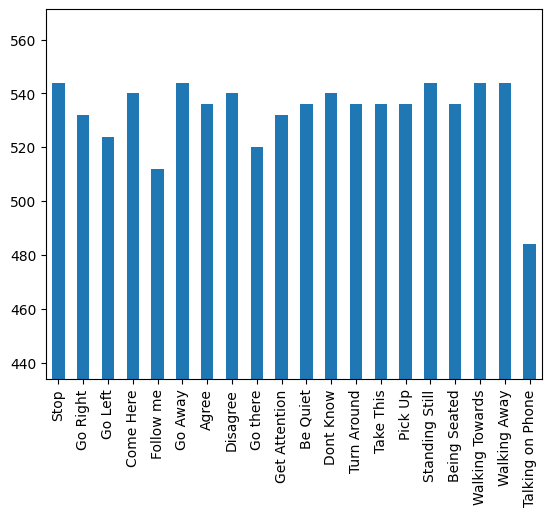

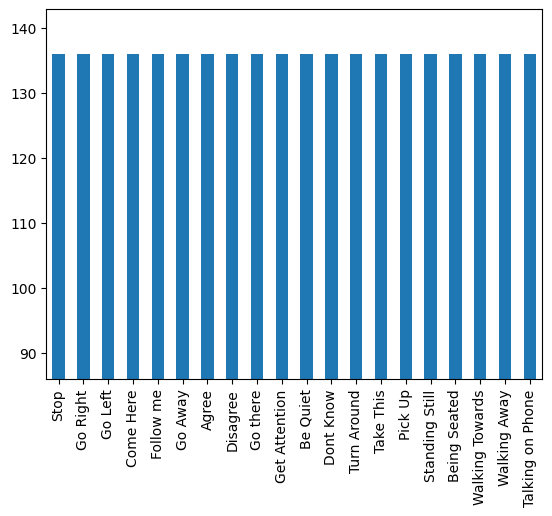

In [75]:
if split:
  plot_label_counts(train_lab)
  plot_label_counts(test_lab)
else:
  plot_label_counts(lab)

#### Data Format and Example Data Sample
 Below you can examine and visualize an example from the dataset in 2D format.

*   Given a recording data[x], where x is the sample number in shape of (number of frames, 17, 5), and a frame number to select the skeleton view from the sample, it generates a plot with the connected joints.
*   When the original data is plotted, the output is upside down. In order to fix it, we multiply the y values with -1.
*   The method can also generate videos by combining the frames given in the sample.

For more info, read the function definition.



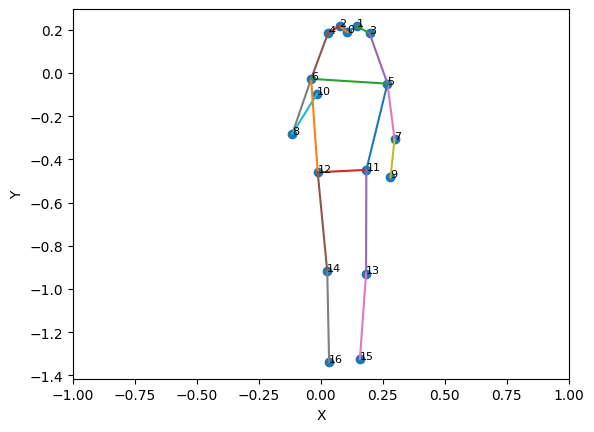

In [76]:
if split:
  samples = train_data
else:
  samples = data
anim = show_skeleton(samples[3], reverse=True, as_video=False, frame=5)
anim

### Preprocessing

#### Filtering

The dataset containg 20 different command labels. We have decided to use only 12 of them for our target case. Therefore, we filter the data by selecting the samples that have these labels.

We, then, print the data size we have and the shortest and longest sequence length.

In [77]:
if split:
  print('Train Data')
  data_filtered_train, labels_filtered_train = filter_data(train_data, train_lab)
  get_min_max_frame_length(data_filtered_train)
  print('----------------')
  print('Test Data')
  data_filtered_test, labels_filtered_test = filter_data(test_data, test_lab)
  get_min_max_frame_length(data_filtered_test)
else:
  data_filtered, labels_filtered = filter_data(data, lab)
  get_min_max_frame_length(data_filtered)

Train Data
Before --- Data length: 10660 - Label length: 10660
After --- Data length: 6372 - Label length: 6372
Min: 56 at 2221 - Max: 88 at 4725
----------------
Test Data
Before --- Data length: 2720 - Label length: 2720
After --- Data length: 1632 - Label length: 1632
Min: 51 at 773 - Max: 88 at 1401


#### Exploration of the Filtered Data
As we did for the whole dataset, here we also examine the imbalance of the filtered data.

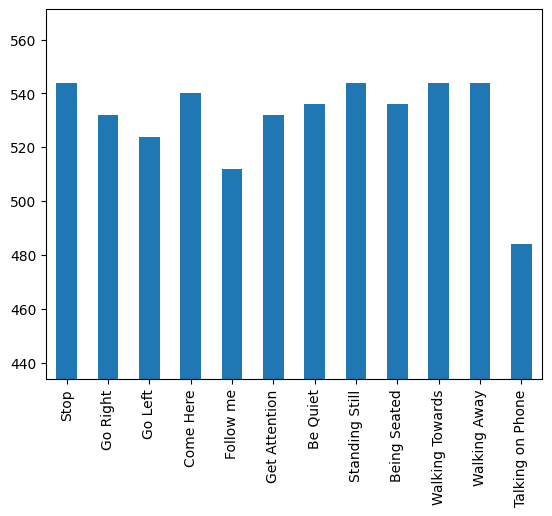

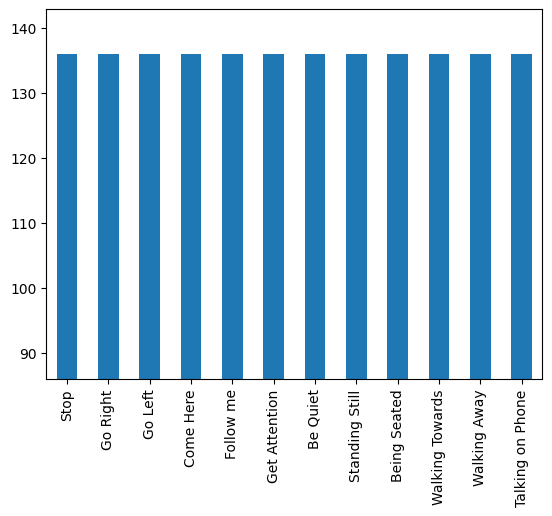

In [78]:
if split:
  plot_label_counts(labels_filtered_train)
  plot_label_counts(labels_filtered_test)
else:
  plot_label_counts(labels_filtered)

In the block below, we merge the train and test data to further more convert them to a consistent type. We also save the merge point to later on split the data again.

In [ ]:
if split:
  split_point = len(labels_filtered_train)
  data_filtered = data_filtered_train + data_filtered_test
  labels_filtered = labels_filtered_train + labels_filtered_test

#### Reformatting

In this block, we reformat the data, so that it is understandable by the model.

1.   Convert the labels into one hot encoding vectors.
2.   Pad the data with zeros to have a unified data structure where each sample has the same sequence length
3.   Reshape the data to use only 2D points. As our target case requires the usage of only 2D information of the detected body keypoints. *(frames, 17, 5) => (frames, 17, 2)*
4.   Reduce dimention *(frames, 17, 2) => (frames, 34)*
5.   For CS and CR experiments we split the test and train data based on the merge point, we saved earlier. For the base experiment we split the data randomly. For both of the cases, we shuffle the data.




In [ ]:
# Get label values
labels_as_num = []
for lab_idx in range(len(labels_filtered)):
  label_key = labels_filtered[lab_idx].upper()
  labels_as_num.append(action_dict[label_key])

# One Hot Encoding of labels
categorical_labels = to_categorical(labels_as_num)

# Pad the sequences to a fixed length
padded_train_data = pad_sequences(data_filtered, padding='post', dtype='float32')

# Reshape the input data to (samples, frames, features as 17x2)
reshaped_train_data = np.reshape(padded_train_data[:,:,:,:2], (padded_train_data.shape[0], padded_train_data.shape[1], -1))

if split:
  X_train = reshaped_train_data[:split_point]
  X_test = reshaped_train_data[split_point:]
  y_train = categorical_labels[:split_point]
  y_test = categorical_labels[split_point:]
  X_train, y_train = shuffle(X_train, y_train)
else:
  # Split train and test and shuffle
  X_train, X_test, y_train, y_test = train_test_split(reshaped_train_data, categorical_labels, train_size=0.8, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(6403, 88, 34)

## Model

The model is built in a heuristik approach.

Each action takes different times to be performed and this might be a useful feature for the model. Because we padded our data and made them all equal sequences, this blocks the model to learn these features. That is why, we first use a Masking layer, which helps the model to remove the effect of padding.

As the maximum sequence length in our dataset is not that long. We thought that an LSTM layer might be sufficient to extract the time based features.

Then we use the output of the LSTM and feed them to a feed forward network. The last layer has *softmax* activation to perform a multi-class classification by distributing the possiblity of the prediction.

* Optimizer: Adam - with default settings
* Loss function: Categorical crossentropy
* Metric: Categorical accuracy
* Total number of trainable parameters: 42,700

In order to use a pretrained and saved model, set *to_train* to *False*



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

to_train=False

if to_train:
  model = keras.Sequential()
  model.add(layers.Masking(mask_value=0, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.LSTM(64))
  model.add(layers.Dense(128))
  model.add(layers.Dense(64))
  model.add(layers.Dense(12, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics="categorical_accuracy")
  model.summary()
else:
  model = keras.models.load_model("/content/drive/MyDrive/CommandRecognition/base_100_bSize32_test20_acc97_91")

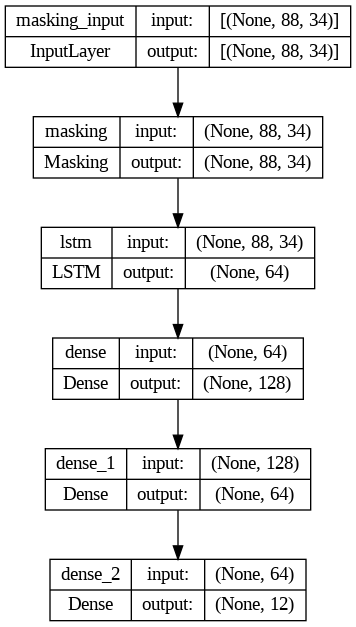

In [81]:
plot_model(model, show_shapes=True)

### Training

We train the model for 100 epochs with a batch size of 32 samples.

In [ ]:
if to_train:
  model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
201/201 [==============================] - 21s 76ms/step - loss: 1.7462 - categorical_accuracy: 0.3761
Epoch 2/100
201/201 [==============================] - 15s 76ms/step - loss: 1.3082 - categorical_accuracy: 0.5326
Epoch 3/100
201/201 [==============================] - 15s 76ms/step - loss: 1.1215 - categorical_accuracy: 0.6014
Epoch 4/100
201/201 [==============================] - 16s 78ms/step - loss: 1.0555 - categorical_accuracy: 0.6255
Epoch 5/100
201/201 [==============================] - 15s 76ms/step - loss: 0.9442 - categorical_accuracy: 0.6611
Epoch 6/100
201/201 [==============================] - 15s 76ms/step - loss: 0.8789 - categorical_accuracy: 0.6895
Epoch 7/100
201/201 [==============================] - 15s 76ms/step - loss: 0.8303 - categorical_accuracy: 0.7142
Epoch 8/100
201/201 [==============================] - 15s 76ms/step - loss: 0.7734 - categorical_accuracy: 0.7333
Epoch 9/100
201/201 [==============================] - 15s 76ms/step - loss: 0.7

### Evaluation

We run the model on the test data and examine the categorical accuracy it achieves.

In [ ]:
model.evaluate(X_test, y_test, batch_size=32)

51/51 [==============================] - 14s 23ms/step - loss: 0.3000 - categorical_accuracy: 0.9132


[0.30002251267433167, 0.9131792783737183]

In [ ]:
model.save('/content/drive/MyDrive/CommandRecognition/cr_100_bSize32_test30_acc97_83')

For a deeper analysis, we get the predictions of the model for the test data. Then, we select the category with the highest possibility.

In [ ]:
preds = np.argmax(model.predict(X_test), axis=1)

51/51 [==============================] - 3s 28ms/step


### Confusion Matrix
We convert the one hot encoding vectors back to categories and also false predictions can be investigated in detail with the use of *false_preds*.

In the plotted confusion matrix, we can see the performance of the model and the categories it fails.

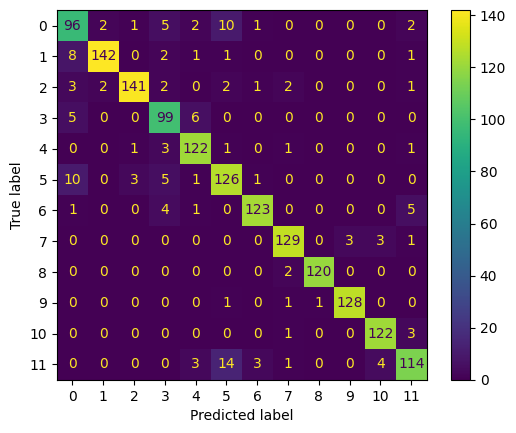

In [ ]:
y_truth = one_hot_to_category_idx(y_test)
false_preds = get_false_preds(y_truth, preds)
plotConfusionMatrix(y_truth, preds)

In [ ]:
print_F1_scores(y_truth, preds)

--------- F1 Scores ---------
STOP: 0.7933884297520661
GO RIGHT: 0.9435215946843853
GO LEFT: 0.94
COME HERE: 0.8608695652173912
FOLLOW ME: 0.9207547169811321
GET ATTENTION: 0.8372093023255814
BE QUIET: 0.935361216730038
STANDING STILL: 0.9450549450549451
BEING SEATED: 0.9876543209876544
WALKING TOWARDS: 0.9770992366412213
WALKING AWAY: 0.9568627450980393
TALKING ON PHONE: 0.853932584269663
Weighted average: 0.9136450199539143
